In [ ]:
# All imports go here

from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import os
from tensorflow.keras.optimizers import Adam

print('Done Importing')

Done Importing


In [ ]:
train = pd.read_csv(r'/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/train_split.csv')
validate = pd.read_csv(r'/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/validate_split.csv')

print(train.head(), end='\n')
print(validate.head(), end='\n')

   Unnamed: 0  ...         file_name
0        2210  ...  9b418ce42c13.png
1         536  ...  263d8851e33b.png
2        1105  ...  4e0656629d02.png
3         452  ...  1fd5d860d4d7.png
4        3624  ...  fd4c946c52bf.png

[5 rows x 5 columns]
   Unnamed: 0  ...         file_name
0         844  ...  3ca8be3b40d6.png
1        2919  ...  cac40227d3b2.png
2         826  ...  3b5dffe159b6.png
3        1059  ...  4bd5d0b30198.png
4        1531  ...  6c00dd8bf708.png

[5 rows x 5 columns]


# Updating CSV for Colab

In [ ]:
train_dir = r'/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/train_images_resized/'

train['file_path'] = train['id_code'].map(
        lambda x: os.path.join(train_dir, '{}.png'.format(x)))
train['file_name'] = train["id_code"].apply(lambda x: x + ".png")

train['diagnosis'] = train['diagnosis'].astype(str)

validate['file_path'] = validate['id_code'].map(
        lambda x: os.path.join(train_dir, '{}.png'.format(x)))
validate['file_name'] = validate["id_code"].apply(lambda x: x + ".png")

validate['diagnosis'] = validate['diagnosis'].astype(str)

train.head()


,Unnamed: 0,id_code,diagnosis,file_path,file_name
0,2210,9b418ce42c13,2,/content/drive/MyDrive/Diabetic Retinopathy Mo...,9b418ce42c13.png
1,536,263d8851e33b,0,/content/drive/MyDrive/Diabetic Retinopathy Mo...,263d8851e33b.png
2,1105,4e0656629d02,1,/content/drive/MyDrive/Diabetic Retinopathy Mo...,4e0656629d02.png
3,452,1fd5d860d4d7,4,/content/drive/MyDrive/Diabetic Retinopathy Mo...,1fd5d860d4d7.png
4,3624,fd4c946c52bf,0,/content/drive/MyDrive/Diabetic Retinopathy Mo...,fd4c946c52bf.png


In [ ]:
validate.head()

,Unnamed: 0,id_code,diagnosis,file_path,file_name
0,844,3ca8be3b40d6,0,/content/drive/MyDrive/Diabetic Retinopathy Mo...,3ca8be3b40d6.png
1,2919,cac40227d3b2,2,/content/drive/MyDrive/Diabetic Retinopathy Mo...,cac40227d3b2.png
2,826,3b5dffe159b6,0,/content/drive/MyDrive/Diabetic Retinopathy Mo...,3b5dffe159b6.png
3,1059,4bd5d0b30198,0,/content/drive/MyDrive/Diabetic Retinopathy Mo...,4bd5d0b30198.png
4,1531,6c00dd8bf708,0,/content/drive/MyDrive/Diabetic Retinopathy Mo...,6c00dd8bf708.png


# Image loader using ImageDataGenerator 

In [ ]:
def img_generator(train):
    HEIGHT = 320
    WIDTH = 320
    BATCH_SIZE = 8

    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.,validation_split = 0.2)
    train_datagen.fit()
# brightness_range=[1.5,2.0]
    train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=r"/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/train_images_resized/",
                                                        x_col="file_name",
                                                        y_col="diagnosis",
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical",
                                                        target_size=(
                                                            HEIGHT, WIDTH),
                                                        subset='training')

    valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=r"/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/train_images_resized/",
                                                        x_col="file_name",
                                                        y_col="diagnosis",
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical",
                                                        target_size=(
                                                            HEIGHT, WIDTH),
                                                        subset='validation')


    return train_generator, valid_generator


In [ ]:
train_data, validate_data = img_generator(train)
print(train_data)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.


# Model Defination

In [ ]:
# Hyper parameters
# Hyper parameters

BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5


# Validation Set Generator

In [ ]:
def validate_dataset():
    valid_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.)

    valid_generator = valid_datagen.flow_from_dataframe(dataframe=validate,
                                                        directory=r"/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/train_images_resized/",
                                                        x_col="file_name",
                                                        y_col="diagnosis",
                                                        batch_size=32,
                                                        class_mode="categorical",
                                                        target_size=(
                                                            HEIGHT, WIDTH),
                                                        )
    return valid_generator


In [ ]:
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(
        weights='imagenet', include_top=False, input_tensor=input_tensor)
    # base_model = ResNet50(
    #     weights=None, include_top=False, input_tensor=input_tensor)
    # base_model.load_weights(
    #     'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model


model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
for layer in model.layers:
    layer.trainable = False
  
for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

# Warming Up for final training

In [ ]:
model.compile(optimizer=Adam(WARMUP_LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy'])
history_warmup = model.fit_generator(train_data, validation_data=validate_data, epochs=WARMUP_EPOCHS, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
293/293 [==============================] - 798s 3s/step - loss: 2.0345 - accuracy: 0.3997 - val_loss: 1.3650 - val_accuracy: 0.4154
Epoch 2/2
293/293 [==============================] - 101s 345ms/step - loss: 1.3886 - accuracy: 0.4454 - val_loss: 1.3114 - val_accuracy: 0.4735


# Actual Training

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_finetunning = model.fit_generator(train_data,
                                          validation_data=validate_data,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
293/293 [==============================] - 146s 496ms/step - loss: 0.3724 - accuracy: 0.8579 - val_loss: 0.4950 - val_accuracy: 0.8034 - lr: 1.2500e-05
Epoch 2/40
293/293 [==============================] - 144s 492ms/step - loss: 0.3528 - accuracy: 0.8660 - val_loss: 0.4883 - val_accuracy: 0.8154 - lr: 1.2500e-05
Epoch 3/40
293/293 [==============================] - 145s 494ms/step - loss: 0.3630 - accuracy: 0.8567 - val_loss: 0.4803 - val_accuracy: 0.8068 - lr: 1.2500e-05
Epoch 4/40
293/293 [==============================] - 145s 494ms/step - loss: 0.3394 - accuracy: 0.8707 - val_loss: 0.4847 - val_accuracy: 0.8068 - lr: 1.2500e-05
Epoch 5/40
293/293 [==============================] - 145s 494ms/step - loss: 0.3439 - accuracy: 0.8720 - val_loss: 0.4933 - val_accuracy: 0.8222 - lr: 1.2500e-05
Epoch 6/40
293/293 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8776
Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
293/293 [=

In [ ]:
model.evaluate(validate_data, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


74/74 [==============================] - 21s 280ms/step - loss: 0.5155 - accuracy: 0.8137


[0.515478789806366, 0.8136752247810364]

In [ ]:
testing_data = validate_dataset()
model.evaluate(testing_data, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 733 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


23/23 [==============================] - 24s 1s/step - loss: 0.4756 - accuracy: 0.8226


[0.47561854124069214, 0.8226466774940491]

In [ ]:
model.save('/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/model_8226.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

test_preds = model.predict(testing_data, verbose=1)
test_labels = [np.argmax(pred) for pred in test_preds]

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

cnf_matrix = confusion_matrix(validate['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
from keras.models import load_model
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
# trained with binary_crossentropy 
model = load_model('/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/model_8085.h5', compile=True)

testing_data = validate_dataset()

test_preds = model.predict(testing_data, verbose=1)
test_labels = [np.argmax(pred) for pred in test_preds]

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

cnf_matrix = confusion_matrix(validate['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

Found 2929 validated image filenames belonging to 5 classes.
92/92 [==============================] - 96s 1s/step


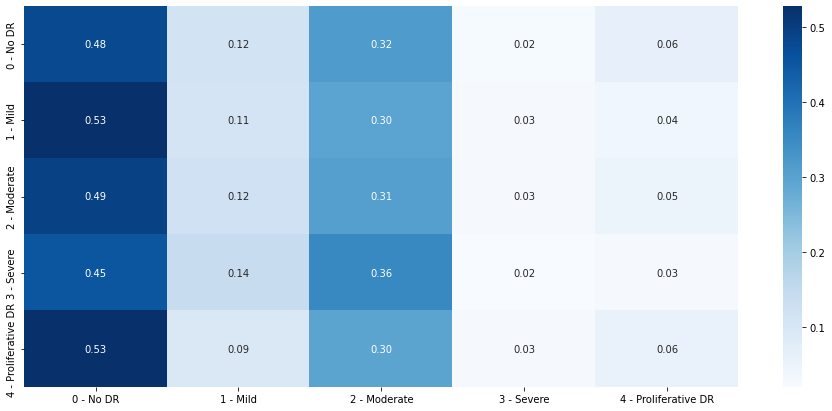

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255, horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,)

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=r"/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/train_images_resized/",
                                                        x_col="file_name",
                                                        y_col="diagnosis",
                                                        batch_size=32,
                                                        class_mode="categorical",
                                                        target_size=(
                                                            HEIGHT, WIDTH),
                                                        )
from keras.models import load_model
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
# trained with binary_crossentropy 
# model = load_model('/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/model_8085.h5', compile=True)

# testing_data = validate_dataset()

test_preds = model.predict(train_generator, verbose=1)
test_labels = [np.argmax(pred) for pred in test_preds]

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
test_preds = model.predict(train_generator, verbose=1)
print(test_preds)

92/92 [==============================] - 93s 1s/step
[[3.0270619e-03 8.6763054e-01 9.4562136e-02 2.5966435e-03 3.2183532e-02]
 [2.5079884e-05 1.3087911e-02 7.0198029e-01 4.4860736e-02 2.4004607e-01]
 [6.6439476e-04 9.9423081e-03 6.4743084e-01 2.2323938e-01 1.1872300e-01]
 ...
 [9.9994767e-01 4.8715428e-05 3.5494993e-06 5.3069948e-09 5.1978034e-08]
 [7.4931812e-03 9.0949482e-01 6.6394918e-02 1.4430680e-03 1.5174083e-02]
 [9.9997878e-01 9.4644429e-06 1.1756234e-05 1.0868849e-09 3.7784172e-08]]


In [ ]:
testing_data = validate_dataset()
test_preds = model.evaluate(testing_data, verbose=1)
print(test_preds)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 733 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


23/23 [==============================] - 24s 1s/step - loss: 0.4922 - accuracy: 0.8226
[0.49215880036354065, 0.8226466774940491]


In [ ]:
# model.save("/content/drive/MyDrive/Diabetic Retinopathy Model /aptos2019-blindness-detection/model_8254.h5")